In this notebook, we are looking for gaps in the audio data collected by one or more badges

In [1]:
from __future__ import absolute_import, division, print_function

import os
import sys
import datetime
import pytz
import dateutil

import pandas as pd
import numpy as np

from ggplot import *
import gzip

%matplotlib inline

# Import the data analysis tools
import openbadge_analysis as ob
import openbadge_analysis.core

/home/orenled/anaconda2/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/orenled/anaconda2/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/orenled/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# config
filename = '../data/hub_data/audio_archive.txt.gz'
log_filename = '../data/hub_data/hub.log.gz'

eastern = pytz.timezone('US/Eastern')
utc  = pytz.timezone('UTC')

# Find badge first reset

If we want to get a real sense of how many gaps we have, we need to discard data after the the badges stared to reset. We need to look at the actualy logfile to find that time. This isn't going to be pretty, but it will work.

In [3]:
# only load lines in which the hub reported a unsynchronized badge
with gzip.open(log_filename, 'r') as f:
    unsync_raw = [ line for line in f if 'unsync' in line]

In [4]:
import re
# use regex to get date and badge
unsync_split = [ re.match('(.*) - INFO - \[(.*)\]',line).group(1,2) for line in unsync_raw]

In [5]:
# load into a dataframe and convert the date
df_log = pd.DataFrame(unsync_split,columns=['datetime','badge_address'])

# Sort by date
df_log['datetime'] = pd.to_datetime(df_log['datetime'], utc=True)
df_log.sort_values('datetime')
df_log.index = pd.to_datetime(df_log.pop('datetime'), utc=True)

# This log is in EST, so let's make the datatime tiemzone aware
# This way we can use it to filter the data
df_log = df_log.tz_localize(eastern)
print(df_log.index.dtype)

datetime64[ns, US/Eastern]


In [6]:
# reseting index, now that we converted the timezone (i'm not sure how to do this more efficiently...)
df_log = df_log.reset_index()
print(df_log.datetime.dtype)

datetime64[ns, US/Eastern]


The first reset (for every badge) is the first time we set the clock, so it's not really a reset - it is the first time we sent the date to the badge

In [7]:
df_log_grp = df_log.groupby('badge_address')
start_time = df_log_grp.nth(0)
print("Start time\n",start_time,"\n\n")

first_reset = df_log_grp.nth(1)
print("First reset\n",first_reset,"\n\n")

# change to a more convinient format
first_reset = first_reset.reset_index()
first_reset.rename(columns={'datetime': 'first_reset_datetime'}, inplace=True)
first_reset['first_reset_timestamp'] = first_reset.pop('first_reset_datetime').astype(np.int64)//1e9
print("First reset, restructured\n", first_reset,"\n\n")

Start time
                                           datetime
badge_address                                     
D8:59:E3:35:BD:C4 2017-06-30 21:43:01.891000-04:00
E0:B2:01:E3:09:8C 2017-06-30 21:42:58.359000-04:00 


First reset
                                           datetime
badge_address                                     
D8:59:E3:35:BD:C4 2017-07-07 05:40:07.516000-04:00
E0:B2:01:E3:09:8C 2017-07-07 00:05:39.844000-04:00 


First reset, restructured
        badge_address  first_reset_timestamp
0  D8:59:E3:35:BD:C4           1.499420e+09
1  E0:B2:01:E3:09:8C           1.499400e+09 




# Look for gaps

In [8]:
# Load audio data
with gzip.open(filename, 'r') as f:
    audio_chunks = ob.core.load_audio_chunks_as_json_objects(f, log_version='2.0')

In [9]:
# load data into a data frame
df = pd.DataFrame(audio_chunks,columns=['badge_address','timestamp'])

# Converting timestamp (epoch) to UTC datetime
df['datetime'] = pd.to_datetime(df['timestamp'],unit='s', utc=True)

# Setting datetime as index
df.sort_values('datetime')
df.index = pd.to_datetime(df.pop('datetime'), utc=True)
df = df.tz_localize(utc)
df = df.tz_convert(eastern)
df = df.reset_index() # make it a column again

print(df.head(10))
print(df.dtypes)

                          datetime      badge_address     timestamp
0 2017-06-30 17:42:58.325000-04:00  E0:B2:01:E3:09:8C  1.498859e+09
1 2017-06-30 17:43:01.845000-04:00  D8:59:E3:35:BD:C4  1.498859e+09
2 2017-06-30 17:42:58.325000-04:00  E0:B2:01:E3:09:8C  1.498859e+09
3 2017-06-30 17:43:04.008000-04:00  E0:B2:01:E3:09:8C  1.498859e+09
4 2017-06-30 17:43:09.707000-04:00  E0:B2:01:E3:09:8C  1.498859e+09
5 2017-06-30 17:43:01.845000-04:00  D8:59:E3:35:BD:C4  1.498859e+09
6 2017-06-30 17:43:07.545000-04:00  D8:59:E3:35:BD:C4  1.498859e+09
7 2017-06-30 17:43:13.242000-04:00  D8:59:E3:35:BD:C4  1.498859e+09
8 2017-06-30 17:43:09.707000-04:00  E0:B2:01:E3:09:8C  1.498859e+09
9 2017-06-30 17:43:15.413000-04:00  E0:B2:01:E3:09:8C  1.498859e+09
datetime         datetime64[ns, US/Eastern]
badge_address                        object
timestamp                           float64
dtype: object


## filter based on first reset time

In [10]:
if (len(first_reset)) > 0:
    df_fil = pd.merge(df,first_reset,how='left',on='badge_address')
    df_fil = df_fil[df_fil['timestamp'] < df_fil['first_reset_timestamp']]
    print("Records before filtering: {}, after: {}".format(len(df),len(df_fil)))

    del df_fil['first_reset_timestamp']
else:
    print("No reset found, using entire dataset")
    df_fil = df

Records before filtering: 282460, after: 276605


## Check for gaps in data

calculations are per-badge, so we must create a multi index. Then, per-group calculations can be done with group by

In [11]:
# http://pandas.pydata.org/pandas-docs/stable/advanced.html
# set multi-index
df_fil.set_index(['badge_address', 'datetime'], inplace=True, drop=False)

# sort is important for shift to work properly
df_fil.sort_index(inplace=True)
print(df_fil.head())

                                                                           datetime  \
badge_address     datetime                                                            
D8:59:E3:35:BD:C4 2017-06-30 17:43:01.845000-04:00 2017-06-30 17:43:01.845000-04:00   
                  2017-06-30 17:43:01.845000-04:00 2017-06-30 17:43:01.845000-04:00   
                  2017-06-30 17:43:07.545000-04:00 2017-06-30 17:43:07.545000-04:00   
                  2017-06-30 17:43:13.242000-04:00 2017-06-30 17:43:13.242000-04:00   
                  2017-06-30 17:43:13.242000-04:00 2017-06-30 17:43:13.242000-04:00   

                                                        badge_address  \
badge_address     datetime                                              
D8:59:E3:35:BD:C4 2017-06-30 17:43:01.845000-04:00  D8:59:E3:35:BD:C4   
                  2017-06-30 17:43:01.845000-04:00  D8:59:E3:35:BD:C4   
                  2017-06-30 17:43:07.545000-04:00  D8:59:E3:35:BD:C4   
                  2017-06

In [12]:
# http://pandas.pydata.org/pandas-docs/stable/groupby.html
# group by badges, and shift ones so we can get the time of the previous row
grp_shift = df_fil.groupby(level=[0]).shift(1)
df_with_lag = df_fil.copy()
df_with_lag['timestamp_lag']= grp_shift['timestamp']
df_with_lag['time_diff']=df_with_lag['timestamp']-df_with_lag['timestamp_lag']
print("index dtype: ",df_with_lag.index.dtype)
print("Timediff type:", df_with_lag.time_diff.dtype)
print(df_with_lag.head())

index dtype:  object
Timediff type: float64
                                                                           datetime  \
badge_address     datetime                                                            
D8:59:E3:35:BD:C4 2017-06-30 17:43:01.845000-04:00 2017-06-30 17:43:01.845000-04:00   
                  2017-06-30 17:43:01.845000-04:00 2017-06-30 17:43:01.845000-04:00   
                  2017-06-30 17:43:07.545000-04:00 2017-06-30 17:43:07.545000-04:00   
                  2017-06-30 17:43:13.242000-04:00 2017-06-30 17:43:13.242000-04:00   
                  2017-06-30 17:43:13.242000-04:00 2017-06-30 17:43:13.242000-04:00   

                                                        badge_address  \
badge_address     datetime                                              
D8:59:E3:35:BD:C4 2017-06-30 17:43:01.845000-04:00  D8:59:E3:35:BD:C4   
                  2017-06-30 17:43:01.845000-04:00  D8:59:E3:35:BD:C4   
                  2017-06-30 17:43:07.545000-04:00  D8

In [13]:
print(len(df_with_lag.groupby(level=0)))

2


There is a sample for every 50 ms, and room for 114 smaples per chunk. Therefore, time between chunks should be AT MOST ~ 5.7 seconds. We'll add 0.2 seconds to get rid of some noise

In [14]:
seconds_between_chunks = 50*114/1000
print("seconds between chunks: {}".format(seconds_between_chunks))

# time between chunks might vary slightly since we update the clock on the badges)
seconds_between_chunks = seconds_between_chunks + 0.2
print("seconds between chunks: {}".format(seconds_between_chunks))

gaps = df_with_lag[df_with_lag['time_diff']>seconds_between_chunks]
print(gaps[['badge_address','datetime','time_diff']].head(10))

seconds between chunks: 5.7
seconds between chunks: 5.9
                                                        badge_address  \
badge_address     datetime                                              
D8:59:E3:35:BD:C4 2017-07-07 01:40:07.481000-04:00  D8:59:E3:35:BD:C4   
                  2017-07-07 01:50:24.752000-04:00  D8:59:E3:35:BD:C4   
                  2017-07-07 02:03:41.204000-04:00  D8:59:E3:35:BD:C4   
                  2017-07-07 02:04:58.282000-04:00  D8:59:E3:35:BD:C4   
                  2017-07-07 02:07:13.907000-04:00  D8:59:E3:35:BD:C4   
                  2017-07-07 02:13:32.158000-04:00  D8:59:E3:35:BD:C4   
                  2017-07-07 02:19:47.197000-04:00  D8:59:E3:35:BD:C4   
                  2017-07-07 02:24:04.182000-04:00  D8:59:E3:35:BD:C4   
                  2017-07-07 02:26:19.869000-04:00  D8:59:E3:35:BD:C4   
                  2017-07-07 02:31:37.372000-04:00  D8:59:E3:35:BD:C4   

                                                                   

How many gaps are ther then? If you look below, you'll see that there are gaps in the data, even before the first reset. However, if you look at the hub_plot_audio_voltage notebook, you will see that these gaps appear only when the battery voltage is very low.

In [15]:
print(len(df))
print(len(gaps))
print(len(gaps)/len(df))

282460
299
0.00105855696382


In [16]:
gaps

datetime  \
badge_address     datetime                                                            
D8:59:E3:35:BD:C4 2017-07-07 01:40:07.481000-04:00 2017-07-07 01:40:07.481000-04:00   
                  2017-07-07 01:50:24.752000-04:00 2017-07-07 01:50:24.752000-04:00   
                  2017-07-07 02:03:41.204000-04:00 2017-07-07 02:03:41.204000-04:00   
                  2017-07-07 02:04:58.282000-04:00 2017-07-07 02:04:58.282000-04:00   
                  2017-07-07 02:07:13.907000-04:00 2017-07-07 02:07:13.907000-04:00   
                  2017-07-07 02:13:32.158000-04:00 2017-07-07 02:13:32.158000-04:00   
                  2017-07-07 02:19:47.197000-04:00 2017-07-07 02:19:47.197000-04:00   
                  2017-07-07 02:24:04.182000-04:00 2017-07-07 02:24:04.182000-04:00   
                  2017-07-07 02:26:19.869000-04:00 2017-07-07 02:26:19.869000-04:00   
                  2017-07-07 02:31:37.372000-04:00 2017-07-07 02:31:37.372000-04:00   
                  2017-07-07 02:34:54.008000-04:00 2017-07-07 02:34:54.008000-04:00   
                  2017-07-07 02:36:10.947000-04:00 2017-07-07 02:36:10.947000-04:00   
                  2017-07-07 02:39:28.468000-04:00 2017-07-07 02:39:28.468000-04:00   
                  2017-07-07 02:40:46.940000-04:00 2017-07-07 02:40:46.940000-04:00   
                  2017-07-07 02:43:04.470000-04:00 2017-07-07 02:43:04.470000-04:00   
                  2017-07-07 02:53:22.259000-04:00 2017-07-07 02:53:22.259000-04:00   
                  2017-07-07 02:55:40.220000-04:00 2017-07-07 02:55:40.220000-04:00   
                  2017-07-07 02:57:55.076000-04:00 2017-07-07 02:57:55.076000-04:00   
                  2017-07-07 02:59:12.716000-04:00 2017-07-07 02:59:12.716000-04:00   
                  2017-07-07 03:01:29.968000-04:00 2017-07-07 03:01:29.968000-04:00   
                  2017-07-07 03:03:46.898000-04:00 2017-07-07 03:03:46.898000-04:00   
                  2017-07-07 03:06:02.170000-04:00 2017-07-07 03:06:02.170000-04:00   
                  2017-07-07 03:07:11.419000-04:00 2017-07-07 03:07:11.419000-04:00   
                  2017-07-07 03:08:20.451000-04:00 2017-07-07 03:08:20.451000-04:00   
                  2017-07-07 03:09:29.097000-04:00 2017-07-07 03:09:29.097000-04:00   
                  2017-07-07 03:10:37.971000-04:00 2017-07-07 03:10:37.971000-04:00   
                  2017-07-07 03:11:53.795000-04:00 2017-07-07 03:11:53.795000-04:00   
                  2017-07-07 03:14:07.697000-04:00 2017-07-07 03:14:07.697000-04:00   
                  2017-07-07 03:15:16.523000-04:00 2017-07-07 03:15:16.523000-04:00   
                  2017-07-07 03:16:24.466000-04:00 2017-07-07 03:16:24.466000-04:00   
...                                                                             ...   
E0:B2:01:E3:09:8C 2017-07-06 23:32:12.178000-04:00 2017-07-06 23:32:12.178000-04:00   
                  2017-07-06 23:33:19.444000-04:00 2017-07-06 23:33:19.444000-04:00   
                  2017-07-06 23:34:26.336000-04:00 2017-07-06 23:34:26.336000-04:00   
                  2017-07-06 23:35:33.022000-04:00 2017-07-06 23:35:33.022000-04:00   
                  2017-07-06 23:36:42.273000-04:00 2017-07-06 23:36:42.273000-04:00   
                  2017-07-06 23:37:49.816000-04:00 2017-07-06 23:37:49.816000-04:00   
                  2017-07-06 23:38:58.035000-04:00 2017-07-06 23:38:58.035000-04:00   
                  2017-07-06 23:40:04.569000-04:00 2017-07-06 23:40:04.569000-04:00   
                  2017-07-06 23:41:12.579000-04:00 2017-07-06 23:41:12.579000-04:00   
                  2017-07-06 23:42:21.537000-04:00 2017-07-06 23:42:21.537000-04:00   
                  2017-07-06 23:43:30.198000-04:00 2017-07-06 23:43:30.198000-04:00   
                  2017-07-06 23:44:37.355000-04:00 2017-07-06 23:44:37.355000-04:00   
                  2017-07-06 23:45:46.759000-04:00 2017-07-06 23:45:46.759000-04:00   
                  2017-07-06 23:46:56.009000-04:00 2017-07-06 23:46:56.00

# Misc analysis of the gaps

In [17]:
gaps[1:2].timestamp.map('{:.3f}'.format)

badge_address      datetime                        
D8:59:E3:35:BD:C4  2017-07-07 01:50:24.752000-04:00    1499406624.752
Name: timestamp, dtype: object

In [18]:
gaps[8:9].timestamp.map('{:.3f}'.format)

badge_address      datetime                        
D8:59:E3:35:BD:C4  2017-07-07 02:26:19.869000-04:00    1499408779.869
Name: timestamp, dtype: object

/home/orenled/anaconda2/lib/python2.7/site-packages/ggplot/ggplot.py:420: FutureWarning: 'badge_address' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  return mappers, data.groupby(groups)


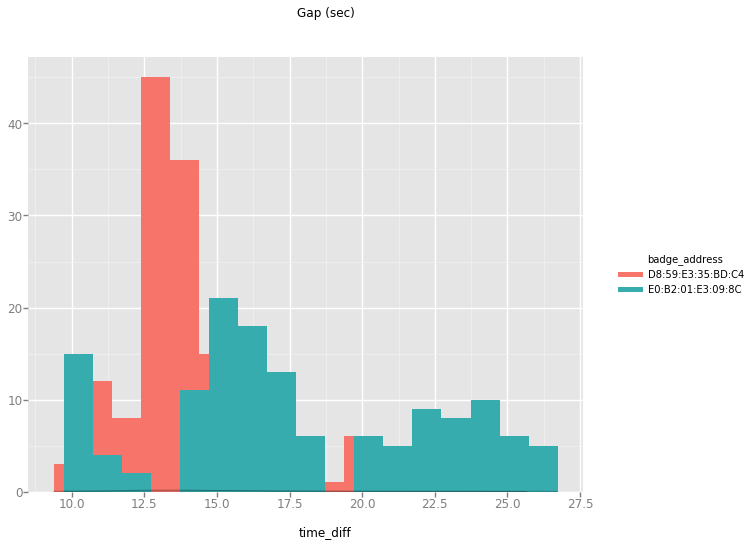

<ggplot: (8744646460225)>

In [19]:
p = ggplot(aes(x='time_diff', fill='badge_address'), data=gaps)
p + geom_histogram(binwidth=1)
p + geom_density(alpha=0.25) 
p + ggtitle("Gap (sec)")